# DSTC9

## Load data

In [1]:
import datetime
import os
import json
import re
from pathlib import Path
from typing import Any, Dict, List, Set


# taxi "table" only has a set of colours, a set of brands ("types"), and a set of possible phone numbers
UNAVAIL_SLOTS = [
    "hotel-bookday",
    "hotel-bookpeople", # hotel-bookpeople based on presence of "single/double/family"?
    "hotel-bookstay",
    "restaurant-bookday",
    "restaurant-bookpeople",
    "restaurant-booktime",
    "taxi-arriveby",
    "taxi-departure",
    "taxi-destination",
    "taxi-leaveat",
    "train-bookpeople"
]

# "bus/train-leaveat" ("I'd like to leave AFTER ..." vs "I'd like to leave BEFORE ...")
EQ_SLOTS = [
    "attraction-area",
    "attraction-name",
    "attraction-type",
    "bus-day",
    "bus-departure",
    "bus-destination",
    "hotel-area",
    "hotel-internet",
    "hotel-name",
    "hotel-parking",
    "hotel-pricerange",
    "hotel-stars", # similar to "-leaveat" (could be in LEQ or GEQ)
    "hotel-type",
    "restaurant-area",
    "restaurant-food",
    "restaurant-name",
    "restaurant-pricerange",
    "train-day",
    "train-departure",
    "train-destination",
]
GEQ_SLOTS = [
    "bus-leaveat",  # could be in LEQ
    "train-leaveat" # could be in LEQ
]
LEQ_SLOTS = [
    "bus-arriveby",
    "train-arriveby"
]

AVAIL_SLOTS = EQ_SLOTS + GEQ_SLOTS + LEQ_SLOTS

SLOT_MAP = {
    "arriveby": "arriveBy",
    "leaveat": "leaveAt",
}

# TIME_SLOTS = ["bus-leaveat", "bus-arriveby", "restaurant-booktime", "taxi-arriveby", "taxi-leaveat", "train-arriveby", "train-leaveat"]
# INT_SLOTS = ["hotel-bookpeople", "hotel-bookstay", "hotel-stars", "restaurant-bookpeople", "train-bookpeople"]
TIME_SLOTS = ["bus-leaveat", "bus-arriveby", "train-arriveby", "train-leaveat"]
INT_SLOTS = ["hotel-stars"]


TIME_PATTERNS = [
    (r"([0-2]?[0-9])(?:\:|\.)?([0-9][0-9])", r"\1:\2"),
    (r"([0-2]?[0-9])", r"\1:00")
]

EMPTY_FIELD_VALUES = ["", "?"]

LONG_FIELDS = ["openhours", "introduction", "signature"]

def str_to_time(time_str: str):
    orig_time_str = time_str
    try:
        # TODO check regex for multiwoz 2.1
        for patt, sub in TIME_PATTERNS:
            comp_patt = re.compile(patt)
            match = comp_patt.match(time_str)
            if match is not None:
                time_str = re.sub(patt, sub, match[0])
                break
        hour, minute = time_str.split(":")
        time = datetime.time(hour=int(hour)%24, minute=int(minute))
    except:
        time = None
    return time

SEP1 = "<SEP1>"
SEP2 = "<SEP2>"

def get_top_k_values(table: str, entries: List[Dict[str,Any]], k: int) -> Dict[str,List[Any]]:
    value_counts = {}
    for entry in entries:
        for field, value in entry.items():
            # skip "null" values ("", "?", ..) for top k
            if value not in EMPTY_FIELD_VALUES:
                # need to be hashable
                if field == "location":
                    # [long, lat]
                    value = SEP1.join([str(v) for v in value])
                if table == "hotel" and field == "price":
                    # {single: 50, double: 90, ...}
                    value = SEP1.join([f"{k}{SEP2}{v}" for k, v in value.items()]) #type: ignore

                if field not in value_counts:
                    value_counts[field] = {}
                if value not in value_counts[field]:
                    value_counts[field][value] = 0
                value_counts[field][value] += 1
    top_k_values = {}
    for field, values in value_counts.items():
        vc_list = [(value, count) for value, count in values.items()]
        sorted_vc_list = sorted(vc_list, key=lambda x: x[1], reverse=True)
        top_k, _ = zip(*sorted_vc_list[:min(k, len(sorted_vc_list))])
        top_k_values[field] = list(top_k)
    # restore location and hotel price
    for field, value in top_k_values.items():
        if field == "location":
            top_k_values[field] = [[e for e in v.split(SEP1)] for v in value]
        if table == "hotel" and field == "price":
            top_k_values[field] = [{e.split(SEP2)[0]: e.split(SEP2)[1] for e in v.split(SEP1)} for v in value] #type: ignore

    return top_k_values

def summarise_query_result(result: Dict[str, List[Dict[str,Any]]], k: int) -> Dict[str, List[Dict[str,Any]]]:
    """
    From list of results to list of top k most common values for each field.
    """
    summarised = {}
    for table, entries in result.items():
        if len(entries) > 1:
            top_k_values = get_top_k_values(table, entries, k)
            # keep same format
            summarised[table] = [top_k_values]
        else:
            summarised[table] = entries
    return summarised


class MwozDataBase:
    def __init__(self, db_path: str, accept_dontcare: bool=False):
        self.db: Dict[str, List[Dict[str,Any]]] = {}
        self.accept_dontcare: bool = accept_dontcare
        self._load_db(db_path)

    def _load_db(self, db_path: str):
        db_files_paths = [os.path.join(db_path, name) for name in os.listdir(db_path) if "_db.json" in name]
        for db_file_path in db_files_paths:
            domain = Path(db_file_path).name.split("_")[0]
            if domain == "taxi":
                # always skip, no db for taxi
                continue
            # TODO analysis for hospital and police
            # skip hospital and police domains
            if "hospital" in domain or "police" in domain:
                continue
            # load data for domain
            with open(db_file_path, "r") as f:
                self.db[domain] = json.load(f)

    def query(self, query: Dict[str,str], exclude_long_fields: bool = False) -> Dict[str, List[Dict[str,Any]]]:
        query_domains = set([slot.split("-")[0] for slot in query.keys()])
        # always remove taxi
        if "taxi" in query_domains:
            query_domains.remove("taxi")
        result = {domain: [] for domain in query_domains}
        for domain in query_domains:
            # consider elements of domain for query
            dom_query = {slot: value for slot, value in query.items() if slot.split("-")[0] == domain}
            dom_query = self._filter_query(dom_query)
            # TODO check what happens: issue with bus
            if domain not in self.db:
                continue
            for entry in self.db[domain]:
                if self._is_match(entry, dom_query):
                    if exclude_long_fields:
                        entry = self._remove_long_fields(entry)
                    result[domain].append(entry)
        return result

    def _remove_long_fields(self, entry: Dict[str, Any]) -> Dict[str, Any]:
        new_entry = {}
        for field, value in entry.items():
            if field not in LONG_FIELDS:
                new_entry[field] = value
        return new_entry

    def _filter_query(self, query: Dict[str, str]) -> Dict[str, str]:
        # depending on the domain, some slots cannot be checked (no information in DB)
        return {slot:value for slot, value in query.items() if slot not in UNAVAIL_SLOTS}


    def _is_match(self, entry: Dict[str, Any], query: Dict[str, str]) -> bool:
        match = True
        for domain_slot, value in query.items():
            assert " " not in domain_slot
            slot = domain_slot.split("-")[1]
            # some slot names are not identical in the database (e.g. arriveby -> arriveBy)
            if slot in SLOT_MAP:
                slot = SLOT_MAP[slot]
            if not self._is_acceptable(domain_slot, value, entry[slot]):
                match = False
                break
        return match

    def _is_acceptable(self, slot: str , value, entry_value) -> bool:
        if value == "dontcare":
            return self.accept_dontcare

        # cast to correct type
        if slot in INT_SLOTS:
            if "|" in value:
                # if alternatives with "|" take first
                value = value.split("|")[0]
            value = int(value)
            entry_value = int(entry_value)
        elif slot in TIME_SLOTS:
            orig_value = value
            value = str_to_time(value)
            entry_value = str_to_time(entry_value)
            # TODO manage some cases
            if value is None:
                return False

        if slot in EQ_SLOTS:
            acceptable = entry_value == value
        elif slot in LEQ_SLOTS:
            acceptable = entry_value <= value # type: ignore
        else: # slot in GEQ_SLOTS
            acceptable = entry_value >= value # type: ignore

        return acceptable

    def get_all_fields(self) -> Dict[str, Set[str]]:
        all_fields = {}
        for table, entries in self.db.items():
            all_fields[table] = set()
            for entry in entries:
                for field in entry.keys():
                    all_fields[table].add(field)
        return all_fields

In [2]:
import os
import json

class KnowledgeReader(object):
    def __init__(self, dataroot, knowledge_file):
        path = os.path.join(os.path.abspath(dataroot))

        with open(os.path.join(path, knowledge_file), 'r') as f:
            self.knowledge = json.load(f)

    def get_domain_list(self):
        return list(self.knowledge.keys())

    def get_entity_list(self, domain):
        if domain not in self.get_domain_list():
            raise ValueError("invalid domain name")

        entity_ids = []
        for entity_id in self.knowledge[domain].keys():
            try:
                entity_id = int(entity_id)
                entity_ids.append(int(entity_id))
            except:
                pass

        result = []
        for entity_id in sorted(entity_ids):
            entity_name = self.knowledge[domain][str(entity_id)]['name']
            result.append({'id': entity_id, 'name': entity_name})

        return result

    def get_entity_name(self, domain, entity_id):
        if domain not in self.get_domain_list():
            raise ValueError("invalid domain name: %s" % domain)

        if str(entity_id) not in self.knowledge[domain]:
            raise ValueError("invalid entity id: %s" % str(entity_id))

        result = self.knowledge[domain][str(entity_id)]['name'] or None

        return result


    def get_doc_list(self, domain=None, entity_id=None):
        if domain is None:
            domain_list = self.get_domain_list()
        else:
            if domain not in self.get_domain_list():
                raise ValueError("invalid domain name: %s" % domain)
            domain_list = [domain]

        result = []
        for domain in domain_list:
            if entity_id is None:
                for item_id, item_obj in self.knowledge[domain].items():
                    item_name = self.get_entity_name(domain, item_id)
                    
                    if item_id != '*':
                        item_id = int(item_id)

                    for doc_id, doc_obj in item_obj['docs'].items():
                        result.append({'domain': domain, 'entity_id': item_id, 'entity_name': item_name, 'doc_id': doc_id, 'doc': {'title': doc_obj['title'], 'body': doc_obj['body']}})
            else:
                if str(entity_id) not in self.knowledge[domain]:
                    raise ValueError("invalid entity id: %s" % str(entity_id))

                entity_name = self.get_entity_name(domain, entity_id)
                
                entity_obj = self.knowledge[domain][str(entity_id)]
                for doc_id, doc_obj in entity_obj['docs'].items():
                    result.append({'domain': domain, 'entity_id': entity_id, 'entity_name': entity_name, 'doc_id': doc_id, 'doc': {'title': doc_obj['title'], 'body': doc_obj['body']}})
        return result

    def get_doc(self, domain, entity_id, doc_id):
        if domain not in self.get_domain_list():
            raise ValueError("invalid domain name: %s" % domain)

        if str(entity_id) not in self.knowledge[domain]:
            raise ValueError("invalid entity id: %s" % str(entity_id))

        entity_name = self.get_entity_name(domain, entity_id)

        if str(doc_id) not in self.knowledge[domain][str(entity_id)]['docs']:
            raise ValueError("invalid doc id: %s" % str(doc_id))

        doc_obj = self.knowledge[domain][str(entity_id)]['docs'][str(doc_id)]
        result = {'domain': domain, 'entity_id': entity_id, 'entity_name': entity_name, 'doc_id': doc_id, 'doc': {'title': doc_obj['title'], 'body': doc_obj['body']}}

        return result

In [3]:
import os
from typing import Any, Dict, List, Optional, Tuple, Union
from torch.utils import data
from tqdm import tqdm

class Dataset(data.Dataset):
    def __init__(
        self,
        data: Dict[int, Dict[str, Union[Any, List[Dict[str, Any]]]]],
        split: str,
        db_path: Optional[str] = None,
        unstr_kb_path: Optional[str] = None,
        **kwargs
    ):
        self.hist: List[List[str]] = []
        self.dialogue_state: List[Dict[str, str]] = []
        self.dialogue_act: List[Dict[str, str]] = []
        self.query_results: List[Dict[str, List[Dict[str,Any]]]] = []
        self.gold_knowledge: List[List[Dict[str,Any]]] = []
        self.retrieved_knowledge: List[List[Dict[str,Any]]] = []
        self.targets: List[str] = []
        self.sample_ids: List[str] = []
        self.db: Optional[MwozDataBase] = None
        self.speakers: List[str] = []
        if db_path is not None:
            self.db = MwozDataBase(db_path, accept_dontcare=True)
        self.unstr_kb: Optional[KnowledgeReader] = None
        if unstr_kb_path is not None:
            self.unstr_kb = KnowledgeReader(unstr_kb_path, "knowledge.json")
            # with open(os.path.join(unstr_kb_path, "knowledge.json")) as f:
            #     kb = json.load(f)

        for dial_id, dial in tqdm(data.items(), desc="Preparing dataset", unit="dialogues"):
            # skip test dialogues that are not from multiwoz 2.1 (no dialogue state annotation)
            if split == "test" and ("source" not in dial or dial["source"] != "multiwoz"):
                continue
            for t_id, turn in enumerate(dial["turns"]):
                history = [t["text"] for t in dial["turns"][:t_id]]
                self.hist.append(history)
                self.dialogue_state.append(turn["dialogue_state"])
                if "dialogue_act" in turn:
                    self.dialogue_act.append(turn["dialogue_act"])
                else:
                    self.dialogue_act.append({})
                self.query_results.append(self._get_query_results(turn))
                self.gold_knowledge.append(self._get_knowledge(turn, "knowledge"))
                self.retrieved_knowledge.append(self._get_knowledge(turn, "top_k"))
                self.targets.append(turn["text"])
                self.sample_ids.append(f"{split}_{dial_id}_{t_id}")
                self.speakers.append("U" if t_id % 2 == 0 else "S")

    def _get_query_results(self, turn: Dict[str, Any]) -> Dict[str, List[Dict[str,Any]]]:
        results = {}
        if self.db:
            results = self.db.query(turn["dialogue_state"], exclude_long_fields=True)
            # summarised = summarise_query_result(results, 3)
        return results

    def _get_knowledge(self, turn: Dict[str, Any], k_field: str="knowledge") -> List[Dict[str,Any]]:
        results = []
        if self.unstr_kb:
            if k_field in turn and turn[k_field] is not None:
                for entry in turn[k_field]:
                    results.append(self.unstr_kb.get_doc(entry["domain"], entry["entity_id"], entry["doc_id"]))
        return results

    def __len__(self):
        return len(self.sample_ids)

    def __getitem__(self, idx) -> Tuple[str, Dict[str, str], Dict[str, str], Dict[str, List[Dict[str,Any]]], List[Dict[str,Any]], List[Dict[str,Any]], str, str, str]:
        return self.hist[idx], self.dialogue_state[idx], self.dialogue_act[idx], self.query_results[idx], self.gold_knowledge[idx], self.retrieved_knowledge[idx], self.speakers[idx], self.targets[idx], self.sample_ids[idx]

In [4]:
def prepare_kb(kb: Dict[str, dict]) -> Dict[str, Dict[tuple, dict]]:
    prepared: Dict[str, Dict[tuple, dict]] = {split:{} for split in kb}
    for split, kb_split in kb.items():
        for domain, entities in kb_split.items():
            for ent_id, entity in entities.items():
                # skip entities not from multiwoz
                if "city" in entity and entity["city"] != "Cambridge":
                    continue
                ent_name = entity["name"]
                if ent_name is None:
                    assert domain in ["taxi", "train"]
                    ent_name = domain.upper()
                for doc_id, doc in entity["docs"].items():
                    prepared[split][(domain, ent_id, doc_id)] = {
                        "ent_name": ent_name,
                        "doc": doc,
                    }
    return prepared

def get_list_and_ids(prep_kb: Dict[str, Dict[tuple, dict]]) -> Tuple[Dict[str, List[str]], Dict[str, List[Dict[str, str]]]]:
    kb_list: Dict[str, List[str]] = {}
    kb_ids: Dict[str, List[Dict[str, str]]] = {}

    for split, kb_split in prep_kb.items():
        kb_tuple = [
            ({"domain": domain, "entity_id": ent_id, "doc_id": doc_id}, f"{doc['ent_name']}, {doc['doc']['title']} {doc['doc']['body']}")
            for (domain, ent_id, doc_id), doc in kb_split.items()
        ]
        kb_ids[split], kb_list[split] = list(zip(*kb_tuple))
        kb_ids[split] = list(kb_ids[split])
        kb_list[split] = list(kb_list[split])

    return kb_list, kb_ids

def get_dstc9_kb():
    kb: Dict[str, dict] = {}
    for split, unstr_kb_path in zip(["train", "test"], ["../original_data/DSTC9/data/", "../original_data/DSTC9/data/"]):
        with open(os.path.join(unstr_kb_path, "knowledge.json")) as f:
            kb_split = json.load(f)
        kb[split] = kb_split
    # prepare kb
    kb: Dict[str, Dict[tuple, dict]] = prepare_kb(kb)
    kb_list, _ = get_list_and_ids(kb)
    return kb_list

## Stats

### Original Stats

In [6]:
import numpy as np

for split in ["train", "valid", "test"]:
    with open(f"../data/DSTC9/{split}.json", "r") as f:
        data = json.load(f)

    turns_per_dial = []
    tokens_per_dial = []
    tokens_per_turn = []
    system_tokens_per_dial = []
    system_tokens_per_turn = []

    for dial in data.values():
        turns_per_dial.append(len(dial["turns"]))
        tokens_in_dial = 0
        system_tokens_in_dial = 0
        for turn in dial["turns"]:
            tokens_per_turn.append(len(turn["text"].split()))
            tokens_in_dial += len(turn["text"].split())
            if turn["speaker"] == "S":
                system_tokens_per_turn.append(len(turn["text"].split()))
                system_tokens_in_dial += len(turn["text"].split())
        tokens_per_dial.append(tokens_in_dial)
        system_tokens_per_dial.append(system_tokens_in_dial)

    print(split.upper())
    print("\t# DIALS:", len(data))
    print("\tAVG # TURNS:", np.mean(turns_per_dial))
    print("\tSTD # TURNS:", np.std(turns_per_dial))
    #print("\tAVG # TOKENS PER TURN:", np.mean(tokens_per_turn))
    #print("\tSTD # TOKENS PER TURN:", np.std(tokens_per_turn))
    #print("\tAVG # TOKENS PER DIAL:", np.mean(tokens_per_dial))
    #print("\tSTD # TOKENS PER DIAL:", np.std(tokens_per_dial))
    print("\tAVG # SYSTEM TOKENS PER TURN:", np.mean(system_tokens_per_turn))
    print("\tSTD # SYSTEM TOKENS PER TURN:", np.std(system_tokens_per_turn))
    print("\tAVG # SYSTEM TOKENS PER DIAL:", np.mean(system_tokens_per_dial))
    print("\tSTD # SYSTEM TOKENS PER DIAL:", np.std(system_tokens_per_dial))

TRAIN
	# DIALS: 7173
	AVG # TURNS: 19.209396347413914
	STD # TURNS: 5.197044258114225
	AVG # SYSTEM TOKENS PER TURN: 16.5461115619593
	STD # SYSTEM TOKENS PER TURN: 6.144795178567002
	AVG # SYSTEM TOKENS PER DIAL: 150.6496584413774
	STD # SYSTEM TOKENS PER DIAL: 45.81300920681529
VALID
	# DIALS: 1000
	AVG # TURNS: 18.65
	STD # TURNS: 5.234644209495045
	AVG # SYSTEM TOKENS PER TURN: 16.465495750708214
	STD # SYSTEM TOKENS PER TURN: 6.06484079560579
	AVG # SYSTEM TOKENS PER DIAL: 145.308
	STD # SYSTEM TOKENS PER DIAL: 46.40085275078466
TEST
	# DIALS: 1984
	AVG # TURNS: 12.015625
	STD # TURNS: 6.08220383085113
	AVG # SYSTEM TOKENS PER TURN: 16.49790233260614
	STD # SYSTEM TOKENS PER TURN: 6.277010422068596
	AVG # SYSTEM TOKENS PER DIAL: 99.1038306451613
	STD # SYSTEM TOKENS PER DIAL: 54.438800218200306


Preparing dataset: 100%|██████████| 1000/1000 [00:00<00:00, 1757.94dialogues/s]


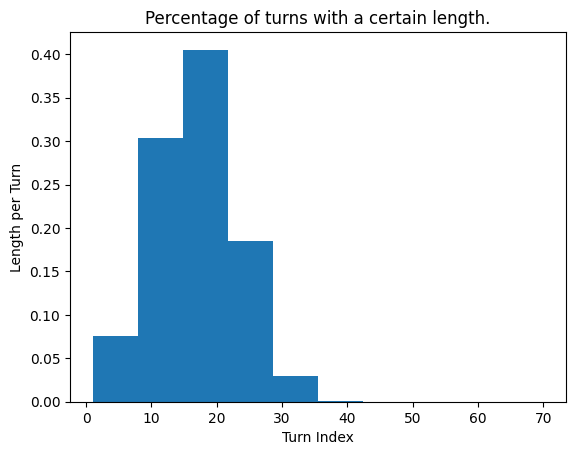

Number of turns 74133


In [7]:
import matplotlib.pyplot as plt


lengths = []
for split in ["train", "valid"]:
    with open(f"../data/DSTC9/{split}.json", "r") as f:
        data = json.load(f)

    ds = Dataset(
        data,
        split=split,
        unstr_kb_path="../original_data/DSTC9/data/" if split != "test" else "../original_data/DSTC9/data_eval/",
    )


    # Calculate the length per turn
    for *_, speaker, target, dialogue_id in ds:
        if speaker == "S":
            lengths.append(len(target.split()))

# Create the bar plot
y, bins, fig = plt.hist(lengths, 10, weights=[1/len(lengths)]*len(lengths))
plt.xlabel("Turn Index")
plt.ylabel("Length per Turn")
plt.title("Percentage of turns with a certain length.")
plt.show()
print(f"Number of turns {len(lengths)}")


Preparing dataset: 100%|██████████| 1000/1000 [00:00<00:00, 10675.16dialogues/s]


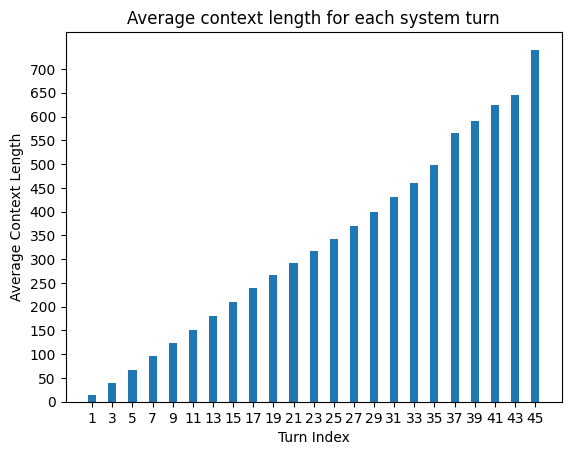

In [8]:
cumulative_lenghts_per_turn = {}

for split in ["train", "valid"]:
    with open(f"../data/DSTC9/{split}.json", "r") as f:
        data = json.load(f)

    ds = Dataset(
        data,
        split=split,
        unstr_kb_path="../original_data/DSTC9/data/" if split != "test" else "../original_data/DSTC9/data_eval/",
    )
    for history, *_, speaker, target, sample_id in ds:
        if speaker == "S":
            turn_id = int(sample_id.split("_")[2])
            if turn_id not in cumulative_lenghts_per_turn:
                cumulative_lenghts_per_turn[turn_id] = []
            cumulative_lenghts_per_turn[turn_id].append(sum([len(utt.split()) for utt in history]))

cumulative_lenghts_per_turn = {k: np.mean(v) for k, v in cumulative_lenghts_per_turn.items()}
plt.bar(cumulative_lenghts_per_turn.keys(), cumulative_lenghts_per_turn.values())
plt.yticks(np.arange(0, max(cumulative_lenghts_per_turn.values())+1, 50))
plt.xticks(np.arange(1, max(cumulative_lenghts_per_turn)+1, 2))
plt.xlabel("Turn Index")
plt.ylabel("Average Context Length")
plt.title("Average context length for each system turn")
plt.show()

Preparing dataset: 100%|██████████| 7173/7173 [00:01<00:00, 6693.61dialogues/s] 


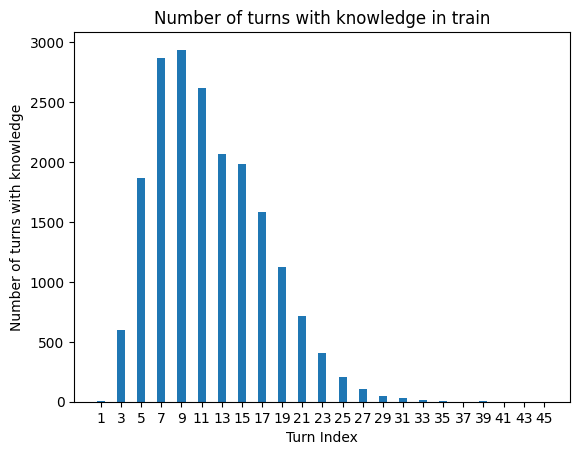

Preparing dataset: 100%|██████████| 1000/1000 [00:00<00:00, 8965.92dialogues/s]


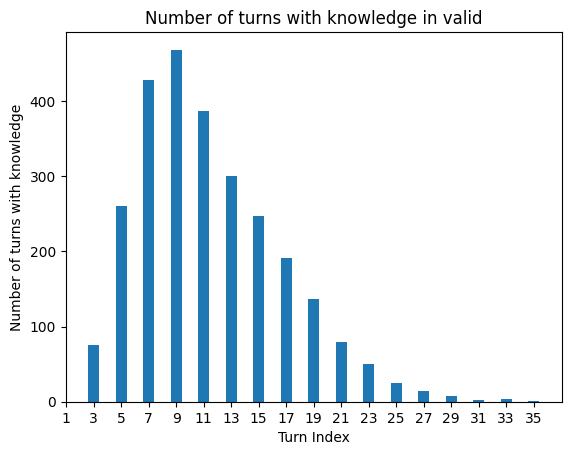

Preparing dataset: 100%|██████████| 1984/1984 [00:00<00:00, 38332.38dialogues/s]


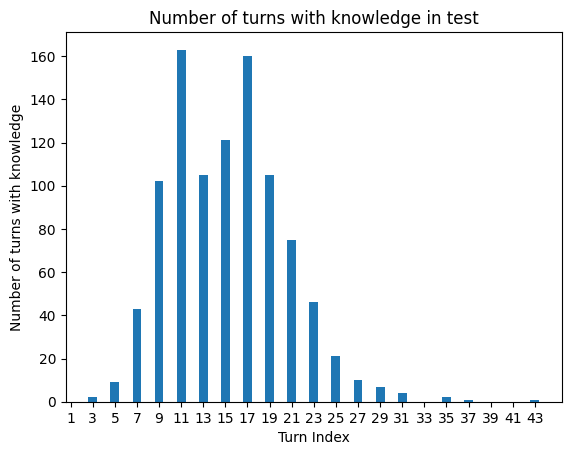

In [9]:
import matplotlib.pyplot as plt
import numpy as np

for split in ["train", "valid", "test"]:
    turns_with_knowledge = {}
    with open(f"../data/DSTC9/{split}.json", "r") as f:
        data = json.load(f)

    ds = Dataset(
        data,
        split=split,
        unstr_kb_path="../original_data/DSTC9/data/" if split != "test" else "../original_data/DSTC9/data_eval/",
    )
    for *_, gold_knowledge, _, speaker, target, sample_id in ds:
        if speaker == "S":
            turn_id = int(sample_id.split("_")[2])
            if len(gold_knowledge) > 0:
                if turn_id not in turns_with_knowledge:
                    turns_with_knowledge[turn_id] = 0
                turns_with_knowledge[turn_id] += 1

    plt.bar(turns_with_knowledge.keys(), turns_with_knowledge.values())
    plt.xticks(np.arange(1, max(turns_with_knowledge)+1, 2))
    plt.xlabel("Turn Index")
    plt.ylabel("Number of turns with knowledge")
    plt.title(f"Number of turns with knowledge in {split}")
    plt.show()

In [10]:
kb = get_dstc9_kb()

print("Number of documents in train & dev:", len(kb["train"]))
print("Number of documents in test:", len(kb["test"]))

Number of documents in train & dev: 2900
Number of documents in test: 2900


### Paper Stats

In [11]:
import numpy as np
from nltk.tokenize import sent_tokenize

for split in ["train", "valid", "test"]:
    with open(f"../data/DSTC9/{split}.json", "r") as f:
        data = json.load(f)

    ds = Dataset(
        data,
        split=split,
        unstr_kb_path="../original_data/DSTC9/data/" if split != "test" else "../original_data/DSTC9/data_eval/",
    )

    turns_per_dial = []
    tokens_per_dial = {}
    tokens_per_turn = []
    sentences_per_turn = []
    system_tokens_per_dial = {}
    system_tokens_per_turn = []
    system_sentences_per_turn = []
    
    for *_, speaker, target, sample_id in tqdm(ds, desc=f"Analysing {split} samples"): # type: ignore
        dialogue_id = int(sample_id.split("_")[1])
        turn_id = int(sample_id.split("_")[2])
        if dialogue_id not in tokens_per_dial:
            tokens_per_dial[dialogue_id] = 0
            system_tokens_per_dial[dialogue_id] = 0
        tokens_per_turn.append(len(target.split()))
        tokens_per_dial[dialogue_id] += len(target.split())
        sentences_per_turn.append(len(sent_tokenize(target)))
        if speaker == "S":
            system_tokens_per_turn.append(len(target.split()))
            system_tokens_per_dial[dialogue_id] += len(target.split())
            system_sentences_per_turn.append(len(sent_tokenize(target)))

    print(split.upper())
    print("\t# DIALS:", len(tokens_per_dial))
    #print("\tAVG # TOKENS PER DIAL", np.mean(list(chain(tokens_per_dial.values()))))
    #print("\tSTD # TOKENS PER DIAL", np.std(list(chain(tokens_per_dial.values()))))
    #print("\tAVG # TOKENS PER TURN", np.mean(tokens_per_turn))
    #print("\tSTD # TOKENS PER TURN", np.std(tokens_per_turn))
    #print("\tAVG # SENTENCES PER TURN", np.mean(sentences_per_turn))
    #print("\tSTD # SENTENCES PER TURN", np.std(sentences_per_turn))
    print("\tAVG # SYSTEM TOKENS PER DIAL", np.mean(list(system_tokens_per_dial.values())))
    print("\tSTD # SYSTEM TOKENS PER DIAL", np.std(list(system_tokens_per_dial.values())))
    print("\tAVG # SYSTEM TOKENS PER TURN", np.mean(system_tokens_per_turn))
    print("\tSTD # SYSTEM TOKENS PER TURN", np.std(system_tokens_per_turn))
    print("\tAVG # SYSTEM SENTENCES PER TURN", np.mean(system_sentences_per_turn))
    print("\tSTD # SYSTEM SENTENCES PER TURN", np.std(system_sentences_per_turn))

    

Analysing train samples: 100%|██████████| 137789/137789 [00:05<00:00, 26127.23it/s]


TRAIN
	# DIALS: 7173
	AVG # SYSTEM TOKENS PER DIAL 150.6481249128677
	STD # SYSTEM TOKENS PER DIAL 45.80852850291536
	AVG # SYSTEM TOKENS PER TURN 16.546196484351075
	STD # SYSTEM TOKENS PER TURN 6.144803898481867
	AVG # SYSTEM SENTENCES PER TURN 1.929641085318797
	STD # SYSTEM SENTENCES PER TURN 0.6935035804298967


Analysing valid samples: 100%|██████████| 18650/18650 [00:00<00:00, 25331.37it/s]


VALID
	# DIALS: 1000
	AVG # SYSTEM TOKENS PER DIAL 145.308
	STD # SYSTEM TOKENS PER DIAL 46.40085275078466
	AVG # SYSTEM TOKENS PER TURN 16.465495750708214
	STD # SYSTEM TOKENS PER TURN 6.06484079560579
	AVG # SYSTEM SENTENCES PER TURN 1.9227195467422096
	STD # SYSTEM SENTENCES PER TURN 0.694885788066249


Analysing test samples: 100%|██████████| 15840/15840 [00:00<00:00, 23475.18it/s]

TEST
	# DIALS: 977
	AVG # SYSTEM TOKENS PER DIAL 135.94882292732856
	STD # SYSTEM TOKENS PER DIAL 45.54206038623535
	AVG # SYSTEM TOKENS PER TURN 16.770454545454545
	STD # SYSTEM TOKENS PER TURN 6.0942169801763075
	AVG # SYSTEM SENTENCES PER TURN 1.9285353535353535
	STD # SYSTEM SENTENCES PER TURN 0.674532293079207


In [13]:
import math

import numpy as np
from nltk.tokenize import sent_tokenize

turns_per_dial = []
tokens_per_dial = {}
tokens_per_turn = []
sentences_per_turn = []
system_tokens_per_dial = {}
system_tokens_per_turn = []
system_sentences_per_turn = []
    
for split in ["train", "valid"]:
    with open(f"../data/DSTC9/{split}.json", "r") as f:
        data = json.load(f)

    ds = Dataset(
        data,
        split=split,
        unstr_kb_path="../original_data/DSTC9/data/" if split != "test" else "../original_data/DSTC9/data_eval/",
    )

    for *_, speaker, target, sample_id in tqdm(ds, desc=f"Analysing {split} samples"): # type: ignore
        dialogue_id = int(sample_id.split("_")[1])
        turn_id = int(sample_id.split("_")[2])
        if dialogue_id not in tokens_per_dial:
            tokens_per_dial[dialogue_id] = 0
            system_tokens_per_dial[dialogue_id] = 0
        tokens_per_turn.append(len(target.split()))
        tokens_per_dial[dialogue_id] += len(target.split())
        sentences_per_turn.append(len(sent_tokenize(target)))
        if speaker == "S":
            system_tokens_per_turn.append(len(target.split()))
            system_tokens_per_dial[dialogue_id] += len(target.split())
            system_sentences_per_turn.append(len(sent_tokenize(target)))

print("TRAIN + VALID")
print("\t# DIALS:", len(tokens_per_dial))
print("\tAVG # SYSTEM TOKENS PER DIAL", np.mean(list(system_tokens_per_dial.values())))
print("\tSTD # SYSTEM TOKENS PER DIAL", np.std(list(system_tokens_per_dial.values())))
print("\tAVG # SYSTEM TOKENS PER TURN", np.mean(system_tokens_per_turn))
print("\tSTD # SYSTEM TOKENS PER TURN", np.std(system_tokens_per_turn))
print("\tAVG # SYSTEM SENTENCES PER TURN", np.mean(system_sentences_per_turn))
print("\tSTD # SYSTEM SENTENCES PER TURN", np.std(system_sentences_per_turn))
print()
print(f"97.7% of SYS sentence have no more than {math.ceil(np.mean(system_tokens_per_turn) + 2*np.std(system_tokens_per_turn))} tokens")
print(f"97.7% of SYS turns have no more than {math.ceil(np.mean(system_sentences_per_turn) + 2*np.std(system_sentences_per_turn))} sentences")


Analysing valid samples: 100%|██████████| 18650/18650 [00:00<00:00, 27118.19it/s]


TRAIN + VALID
	# DIALS: 7173
	AVG # SYSTEM TOKENS PER DIAL 170.90575770249546
	STD # SYSTEM TOKENS PER DIAL 78.72561775122408
	AVG # SYSTEM TOKENS PER TURN 16.53658964293904
	STD # SYSTEM TOKENS PER TURN 6.135395174126212
	AVG # SYSTEM SENTENCES PER TURN 1.9288171259762859
	STD # SYSTEM SENTENCES PER TURN 0.6936718881491153

97.7% of SYS sentence have no more than 29 tokens
97.7% of SYS turns have no more than 4 sentences


## Retrieval Stats

#### Document-level

In [11]:
import json
from tqdm import tqdm

for split in ["train", "valid", "test"]:
    with open(f"../data/DSTC9/{split}.json", "r") as f:
        data = json.load(f)

    ds = Dataset(
        data,
        split=split,
        unstr_kb_path="../original_data/DSTC9/data/" if split != "test" else "../original_data/DSTC9/data_eval/",
    )

    top_k_accuracy = {1: 0.0, 3: 0.0, 5: 0.0}
    valid_turns = 0
    for *_, gold_knowledge, retrieved_knowledge, speaker, _, _ in tqdm(ds, desc=f"Analysing {split} samples"): # type: ignore
        if speaker == "U":
            continue
        if len(gold_knowledge) <= 0:
            continue
        valid_turns += 1
        gold_knowledge = gold_knowledge[0]
        retrieved_knowledge = [(doc["domain"], str(doc["entity_id"]), str(doc["doc_id"])) for doc in retrieved_knowledge]
        for i in [1, 3, 5]:
            for domain, entity_id, doc_id in retrieved_knowledge[:i]:
                if domain == gold_knowledge["domain"] and entity_id == str(gold_knowledge["entity_id"]) and doc_id == str(gold_knowledge["doc_id"]):
                    top_k_accuracy[i] += 1
                    break
    for i in [1, 3, 5]:
        top_k_accuracy[i] /= valid_turns
        print(f"\tRecall@{i} for {split}: {top_k_accuracy[i]*100}")

Analysing train samples: 100%|██████████| 137789/137789 [00:00<00:00, 619341.87it/s]


	Recall@1 for train: 11.25417014178482
	Recall@3 for train: 19.537114261884906
	Recall@5 for train: 24.061718098415348


Analysing valid samples: 100%|██████████| 18650/18650 [00:00<00:00, 438530.58it/s]


	Recall@1 for valid: 13.393191170968949
	Recall@3 for valid: 24.354657687991022
	Recall@5 for valid: 29.068462401795735


Analysing test samples: 100%|██████████| 15840/15840 [00:00<00:00, 659726.68it/s]

	Recall@1 for test: 7.471852610030706
	Recall@3 for test: 12.18014329580348
	Recall@5 for test: 15.86489252814739


#### Domain-level

In [12]:
import json
from tqdm import tqdm

for split in ["train", "valid", "test"]:
    with open(f"../data/DSTC9/{split}.json", "r") as f:
        data = json.load(f)

    ds = Dataset(
        data,
        split=split,
        unstr_kb_path="../original_data/DSTC9/data/" if split != "test" else "../original_data/DSTC9/data_eval/",
    )

    top_k_accuracy = {1: 0.0, 3: 0.0, 5: 0.0}
    valid_turns = 0
    for *_, gold_knowledge, retrieved_knowledge, speaker, _, _ in tqdm(ds, desc=f"Analysing {split} samples"): # type: ignore
        if speaker == "U":
            continue
        if len(gold_knowledge) <= 0:
            continue
        valid_turns += 1
        gold_knowledge = gold_knowledge[0]
        retrieved_knowledge = [(doc["domain"], str(doc["entity_id"]), str(doc["doc_id"])) for doc in retrieved_knowledge]
        for i in [1, 3, 5]:
            for domain, entity_id, doc_id in retrieved_knowledge[:i]:
                if domain == gold_knowledge["domain"]:
                    top_k_accuracy[i] += 1
                    break
    for i in [1, 3, 5]:
        top_k_accuracy[i] /= valid_turns
        print(f"\tRecall@{i} for {split}: {top_k_accuracy[i]*100}")

Analysing train samples: 100%|██████████| 137789/137789 [00:00<00:00, 614272.38it/s]


	Recall@1 for train: 71.9140950792327
	Recall@3 for train: 79.36822351959967
	Recall@5 for train: 82.20391993327773


Analysing valid samples: 100%|██████████| 18650/18650 [00:00<00:00, 465498.53it/s]


	Recall@1 for valid: 72.61503928170595
	Recall@3 for valid: 80.17209128320239
	Recall@5 for valid: 82.67863823419378


Analysing test samples: 100%|██████████| 15840/15840 [00:00<00:00, 675331.63it/s]

	Recall@1 for test: 59.26305015353122
	Recall@3 for test: 66.32548618219037
	Recall@5 for test: 68.98669396110543


#### Entity-level

In [14]:
import json
from tqdm import tqdm

for split in ["train", "valid", "test"]:
    with open(f"../data/DSTC9/{split}.json", "r") as f:
        data = json.load(f)

    ds = Dataset(
        data,
        split=split,
        unstr_kb_path="../original_data/DSTC9/data/" if split != "test" else "../original_data/DSTC9/data_eval/",
    )

    top_k_accuracy = {1: 0.0, 3: 0.0, 5: 0.0}
    valid_turns = 0
    for *_, gold_knowledge, retrieved_knowledge, speaker, _, _ in tqdm(ds, desc=f"Analysing {split} samples"): # type: ignore
        if speaker == "U":
            continue
        if len(gold_knowledge) <= 0:
            continue
        valid_turns += 1
        gold_knowledge = gold_knowledge[0]
        retrieved_knowledge = [(doc["domain"], str(doc["entity_id"]), str(doc["doc_id"])) for doc in retrieved_knowledge]
        for i in [1, 3, 5]:
            for domain, entity_id, doc_id in retrieved_knowledge[:i]:
                if domain == gold_knowledge["domain"] and entity_id == str(gold_knowledge["entity_id"]):
                    top_k_accuracy[i] += 1
                    break
    for i in [1, 3, 5]:
        top_k_accuracy[i] /= valid_turns
        print(f"\tRecall@{i} for {split}: {top_k_accuracy[i]*100}")

Analysing train samples: 100%|██████████| 137789/137789 [00:00<00:00, 660174.10it/s]


	Recall@1 for train: 37.79190992493745
	Recall@3 for train: 47.388448707256046
	Recall@5 for train: 52.204962468723934


Analysing valid samples: 100%|██████████| 18650/18650 [00:00<00:00, 463704.89it/s]


	Recall@1 for valid: 42.61129816685372
	Recall@3 for valid: 51.14104002992892
	Recall@5 for valid: 54.84474373363262


Analysing test samples: 100%|██████████| 15840/15840 [00:00<00:00, 687718.93it/s]

	Recall@1 for test: 30.60388945752303
	Recall@3 for test: 38.68986693961106
	Recall@5 for test: 42.272262026612076


## Generation stats

In [1]:
from utils import collect_task_replies

task_replies = collect_task_replies("../output/DSTC9/")

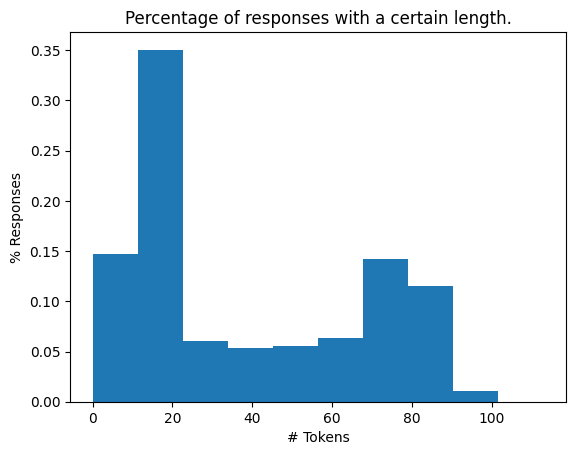

# candidates 126720


In [2]:
import matplotlib.pyplot as plt

lengths = []
for sample_id, sample in task_replies.items():
    for c_name, candidate in sample.items():
        if c_name == "gt":
            continue
        lengths.append(len(candidate.split()))

y, bins, fig = plt.hist(lengths, 10, weights=[1/len(lengths)]*len(lengths))
plt.xlabel("# Tokens")
plt.ylabel("% Responses")
plt.title("Percentage of responses with a certain length.")
plt.show()
print(f"# candidates {len(lengths)}")


In [4]:
len_threshold = 75
lengths_lower_than_threshold = [l for l in lengths if l <= len_threshold]
print(f"Percentage of responses with length lower than {len_threshold}: {round(len(lengths_lower_than_threshold)/len(lengths)*100, 2)}%")

Percentage of responses with length lower than 75: 81.38%


## Sample dialogues for human evaluation

#### Random Sampling

In [5]:
import json

from tqdm import tqdm

from utils import collect_task_replies, fix_replies_if_necessary

task_replies = collect_task_replies("../output/DSTC9")

with open("../data/DSTC9/test.json", "r") as f:
    data = json.load(f)

ds = Dataset(
    data,
    split="test",
    unstr_kb_path="../original_data/DSTC9/data_eval/",
)

possible_samples = 0
valid_samples = {
    "with_knowledge": {},
    "without_knowledge": {}
}
for history, _, _, _, gold_knowledge, _, speaker, _, sample_id in tqdm(ds, desc="Processing samples"): # type: ignore
    dialogue_id = int(sample_id.split("_")[1])
    turn_id = int(sample_id.split("_")[2])

    if speaker == "U":
        continue

    if turn_id not in [5, 7]:
        continue
    possible_samples += 1

    has_knowledge = len(gold_knowledge) > 0

    if has_knowledge:
        key = "with_knowledge"
    else:
        key = "without_knowledge"

    replies = {model: reply.lower() for model, reply in task_replies[sample_id].items()}

    try:
        candidates = fix_replies_if_necessary(replies, max_tokens=29, max_sentences=4, max_candidate_length=75)
    except:
        continue

    identical_candidates = {}
    for c_name, c in candidates.items():
        remaining_candidates = [value for key, value in candidates.items() if key != c_name]
        if c in remaining_candidates:
            if c not in identical_candidates:
                identical_candidates[c] = []
            identical_candidates[c].append(c_name)

    new_candidates = {}
    for c_name, c in candidates.items():
        if c not in identical_candidates:
            new_candidates[c_name] = c
    
    for c in identical_candidates:
        if "gt" in identical_candidates[c]:
            c_name = "gt"
        else:
            c_name = identical_candidates[c][0]
        new_candidates[c_name] = c

    if dialogue_id not in valid_samples[key]:
        valid_samples[key][dialogue_id] = {}

    valid_samples[key][dialogue_id][sample_id] = {
        "sample_id": sample_id,
        "dialogue_id": dialogue_id,
        "turn_id": turn_id,
        "history": [turn.lower() for turn in history],
        "candidates": new_candidates,
        "idenitical_candidates": identical_candidates,
        "has_knowledge": len(gold_knowledge) > 0,
    }

print("Number of samples at turn 5 and 7:", possible_samples)
print("Number of valid samples:", len(set(list(valid_samples["with_knowledge"].keys()) + list(valid_samples["without_knowledge"].keys()))))

Processing samples: 100%|██████████| 15840/15840 [00:01<00:00, 8147.62it/s]

Number of samples at turn 5 and 7: 1941
Number of valid samples: 968


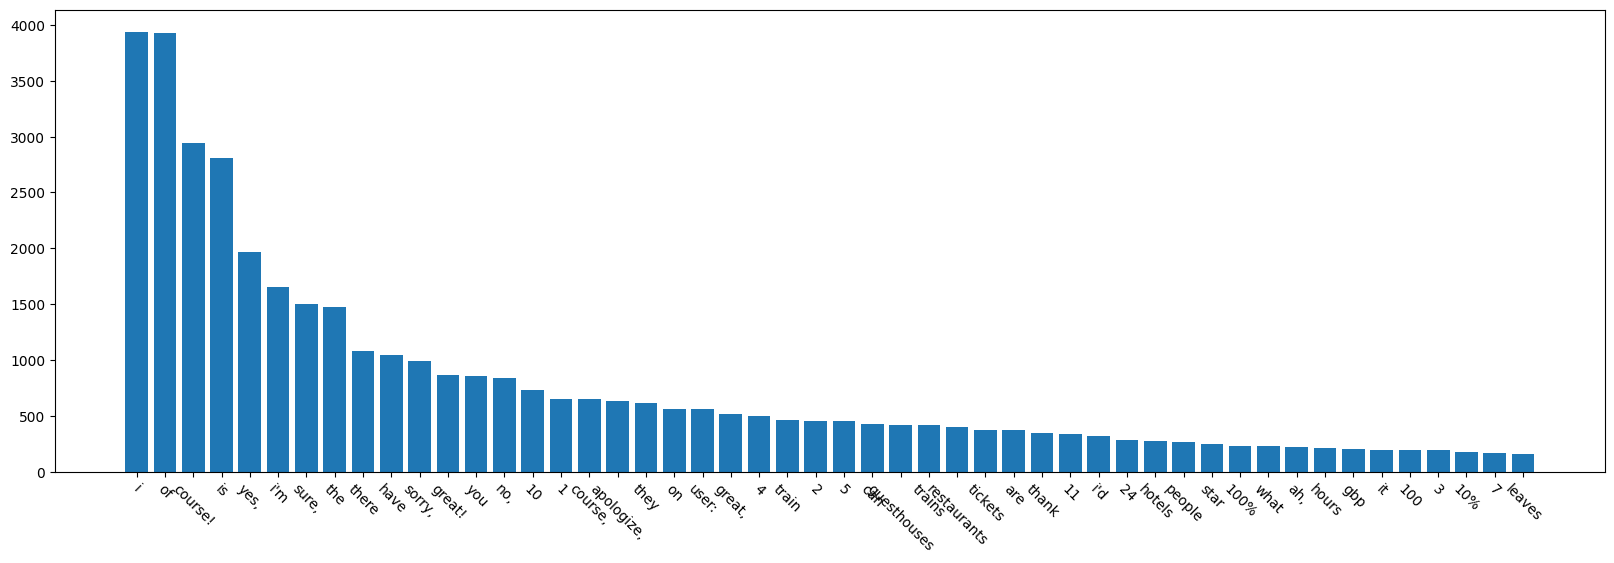

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

tokens = Counter()
for categories in valid_samples.values():
    for samples_per_dialogue in categories.values():
        for sample in samples_per_dialogue.values():
            for candidate in sample["candidates"].values():
                tokens.update([w.lower() for w in candidate.split()[:2]])


most_common = tokens.most_common(200)

plt.figure(figsize=(20, 6))
plt.bar([k[0] for k in most_common[:50]], [k[1] for k in most_common[:50]])
plt.xticks(rotation=-45)
plt.show()



In [7]:
print("Number of valid samples with knowledge:", len(valid_samples["with_knowledge"]))
print("Number of valid samples without knowledge:", len(valid_samples["without_knowledge"]))

Number of valid samples with knowledge: 48
Number of valid samples without knowledge: 956


In [7]:
import os
import random
from statistics import mean

from utils import get_candidates_per_batch

random.seed(7)

n_dial_to_sample = 10
samples_to_eval = {}
dialogue_blacklist = set()

blacklist = [
    3250,
    2582,
    3361,
    2244,
    3442
]

max_history_tokens = 0
max_history_chars = 0
dialogue_keys = list(valid_samples["with_knowledge"])
for dialogue_id in blacklist:
    if dialogue_id in dialogue_keys:
        dialogue_keys.remove(dialogue_id)

random.shuffle(dialogue_keys)
for dialogue_id in dialogue_keys[:n_dial_to_sample]:
    dialogue_blacklist.add(dialogue_id)
    sample_id = random.sample(list(valid_samples["with_knowledge"][dialogue_id].keys()), 1).pop()
    samples_to_eval[sample_id] = valid_samples["with_knowledge"][dialogue_id][sample_id]
    sample = samples_to_eval[sample_id]

    max_history_tokens = max(max_history_tokens, sum([len(turn.split()) for turn in sample["history"]]))
    max_history_chars = max(max_history_chars, sum([len(turn) for turn in sample["history"]]))

assert len(dialogue_blacklist) == n_dial_to_sample, dialogue_blacklist
n_samples_with_knowledge = len(samples_to_eval)
print("Number of sampled dialogues with knowledge:", len(samples_to_eval))


dialogue_keys = [dialogue_id for dialogue_id in valid_samples["without_knowledge"] if dialogue_id not in dialogue_blacklist]
for dialogue_id in blacklist:
    if dialogue_id in dialogue_keys:
        dialogue_keys.remove(dialogue_id)

random.shuffle(dialogue_keys)
for dialogue_id in dialogue_keys[:n_dial_to_sample]:
    dialogue_blacklist.add(dialogue_id)
    sample_id = random.sample(list(valid_samples["without_knowledge"][dialogue_id].keys()), 1).pop()
    samples_to_eval[sample_id] = valid_samples["without_knowledge"][dialogue_id][sample_id]
    sample = samples_to_eval[sample_id]

    max_history_tokens = max(max_history_tokens, sum([len(turn.split()) for turn in sample["history"]]))
    max_history_chars = max(max_history_chars, sum([len(turn) for turn in sample["history"]]))

assert len(dialogue_blacklist) == n_dial_to_sample*2, dialogue_blacklist
print("Number of sampled dialogues without knowledge:", len(samples_to_eval) - n_samples_with_knowledge)

print("Max Token in History:", max_history_tokens)
print("Max Characters in History:", max_history_chars)

with open("../data/DSTC9/samples_to_eval.json", "w") as f:
    json.dump(samples_to_eval, f, indent=4)

for sample in task_replies.values():
    model_candidates = list(sample.keys())
    break

print("Number of candidates:", len(model_candidates))

candidates_per_batch = get_candidates_per_batch(model_candidates, 4)

for batch_id, candidates in enumerate(candidates_per_batch):
    samples_per_batch_to_eval = {}
    actual_candidates = []
    for sample_id, sample in samples_to_eval.items():
        samples_per_batch_to_eval[sample_id] = {
            "sample_id": sample_id,
            "dialogue_id": sample["dialogue_id"],
            "turn_id": sample["turn_id"],
            "history": sample["history"],
            "candidates": {model: sample["candidates"][model] for model in candidates if model in sample["candidates"]},
            "has_knowledge": sample["has_knowledge"],
        }
        # add the ground truth
        samples_per_batch_to_eval[sample_id]["candidates"]["gt"] = sample["candidates"]["gt"]
        actual_candidates.append(len(samples_per_batch_to_eval[sample_id]["candidates"]))
    print(f"Number of samples in batch {batch_id}:", len(samples_per_batch_to_eval))
    print(f"\tAvg Number of candidates in batch {batch_id}:", mean(actual_candidates))
    print(f"\tMin number of candidates in batch {batch_id}:", min(actual_candidates))
    print(f"\tMax number of candidates in batch {batch_id}:", max(actual_candidates))

    out_folder = f"../data/DSTC9/human_eval/batch_{batch_id}"
    os.makedirs(out_folder, exist_ok=True)
    with open(f"{out_folder}/samples_to_eval.json", "w") as f:
        json.dump(samples_per_batch_to_eval, f, indent=4)

Number of sampled dialogues with knowledge: 10
Number of sampled dialogues without knowledge: 10
Max Token in History: 115
Max Characters in History: 633
Number of candidates: 17
Number of samples in batch 0: 20
	Avg Number of candidates in batch 0: 4.9
	Min number of candidates in batch 0: 4
	Max number of candidates in batch 0: 5
Number of samples in batch 1: 20
	Avg Number of candidates in batch 1: 4.7
	Min number of candidates in batch 1: 3
	Max number of candidates in batch 1: 5
Number of samples in batch 2: 20
	Avg Number of candidates in batch 2: 4.95
	Min number of candidates in batch 2: 4
	Max number of candidates in batch 2: 5
Number of samples in batch 3: 20
	Avg Number of candidates in batch 3: 4.55
	Min number of candidates in batch 3: 3
	Max number of candidates in batch 3: 5


## Sample dialogues for generation

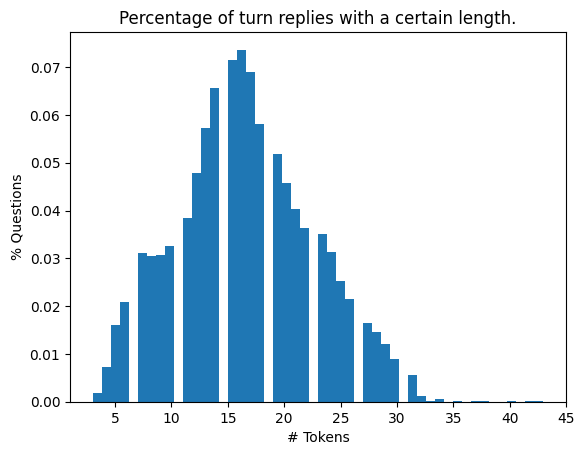

Number of turns 8825


In [5]:
import matplotlib.pyplot as plt


lengths = []
for *_, target, sample_id in dev_ds:
        lengths.append(len(target.split()))

# Create the bar plot
y, bins, fig = plt.hist(lengths, 50, weights=[1/len(lengths)]*len(lengths))
plt.xlabel("# Tokens")
plt.ylabel("% Questions")
plt.title("Percentage of turn replies with a certain length.")
plt.show()
print(f"Number of turns {len(lengths)}")

In [6]:
from tqdm import tqdm
import random

def prepare_split(samples, bins, split_size):

    random.seed(42)
    dataset = {}
    for history, dialogue_state, dialogue_act, query_results, gold_knowledge, retrieved_knowledge, target, sample_id in tqdm(samples, desc=f"Preparing Stratified split"):
        for i, bin in enumerate(bins[1:]):
            if len(target.split()) <= bin:
                if i not in dataset:
                    dataset[i] = []
                dataset[i].append({
                    "history": history,
                    "dialogue_state": dialogue_state,
                    "dialogue_act": dialogue_act,
                    "query_results": query_results,
                    "gold_knowledge": gold_knowledge,
                    "retrieved_knowledge": retrieved_knowledge,
                    "target": target,
                    "sample_id": sample_id
                })
                break
    splits = []
    for i, split in dataset.items():
        try:
            splits += random.sample(split, int(len(split) * split_size))
        except ValueError:
            continue

    return splits

In [7]:
splits = prepare_split(dev_ds, bins, 0.1)
len(splits)

Preparing Stratified split:   0%|          | 0/8825 [00:00<?, ?it/s]

Preparing Stratified split: 100%|██████████| 8825/8825 [00:00<00:00, 62386.20it/s]


869

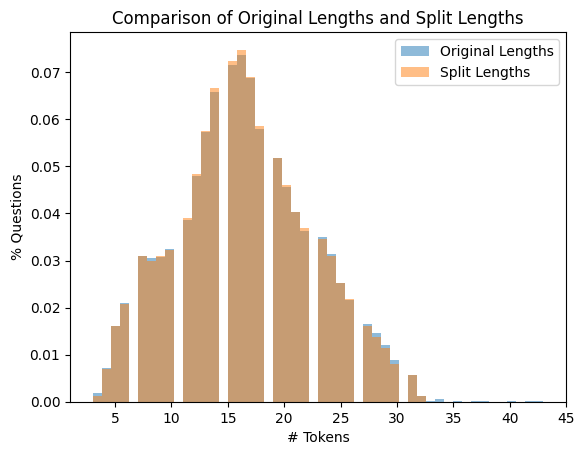

In [8]:
plt.hist(lengths, bins, weights=[1/len(lengths)]*len(lengths), alpha=0.5, label='Original Lengths')
plt.hist([len(sample["target"].split()) for sample in splits], bins, weights=[1/len(splits)]*len(splits), alpha=0.5, label='Split Lengths')
plt.xlabel("# Tokens")
plt.ylabel("% Questions")
plt.title("Comparison of Original Lengths and Split Lengths")
plt.legend()
plt.show()


In [10]:
with open("valid_optimization.json", "w") as f:
    json.dump(splits, f, indent=4)

In [11]:
from transformers import AutoTokenizer

llama = "meta-llama/Llama-2-7b-chat-hf"
mistral = "mistralai/Mistral-7B-Instruct-v0.1"

/home/simone/miniconda3/envs/inlg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import statistics

tokenizer = AutoTokenizer.from_pretrained(llama)

lengths = []
for sample in splits:
    sample["input_ids"] = tokenizer(sample["target"])
    lengths.append(len(sample["input_ids"]["input_ids"]))

max_length = max(lengths)
mean_length = statistics.mean(lengths)

print("Maximum Length:", max_length)
print("Mean Length:", mean_length)


Maximum Length: 67
Mean Length: 24.927502876869966


In [17]:
from tqdm import tqdm
import statistics

tokenizer = AutoTokenizer.from_pretrained(llama)

lengths = []
for *_, target, _ in tqdm(dev_ds):
    lengths.append(len(tokenizer(target)["input_ids"]))

max_length = max(lengths)
mean_length = statistics.mean(lengths)

print("Maximum Length:", max_length)
print("Mean Length:", mean_length)


100%|██████████| 8825/8825 [00:00<00:00, 16649.81it/s]

Maximum Length: 88
Mean Length: 25.176203966005666


## Error Analysis

In [7]:

import json
from pathlib import Path

from parlai.core.metrics import TeacherMetrics
from tqdm import tqdm

from utils import collect_task_replies

with open("../data/DSTC9/test.json", "r") as f:
    data = json.load(f)
    ds = Dataset(
        data,
        split="test",
        unstr_kb_path="../original_data/DSTC9/data_eval/",
    )

task_replies = collect_task_replies("../output/DSTC9/")

Preparing dataset: 100%|██████████| 1984/1984 [00:00<00:00, 36573.36dialogues/s]


### BLEU

In [8]:
techniques = {}
for *_, gold_knowledge, retrieved_knowledge, speaker, target, sample_id in tqdm(ds, desc="Computing BLEU"):
    if speaker == "U":
        continue
    for key, value in task_replies[sample_id].items():
        if key == "gt":
            continue
        if key not in techniques:
            techniques[key] = TeacherMetrics()
        techniques[key].evaluate_response({"text": value}, [target])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['bleu-4']}")

Computing BLEU:   5%|▍         | 718/15840 [00:01<00:29, 504.82it/s]

Computing BLEU: 100%|██████████| 15840/15840 [00:27<00:00, 585.99it/s]

llama_prompt_gold: 0.01072
llama_ft_gold: 0.05386
llama_ft_retrieved_top-3: 0.04333
llama_prompt_retrieved_top-3: 0.008266
llama_ft_none: 0.06725
llama_prompt_none: 0.008457
llama_prompt_retrieved_top-1: 0.00816
llama_ft_retrieved_top-1: 0.04991
mistral_prompt_gold: 0.0133
mistral_ft_gold: 0.03936
mistral_ft_retrieved_top-3: 0.03846
mistral_prompt_retrieved_top-3: 0.01063
mistral_ft_none: 0.0499
mistral_prompt_none: 0.01327
mistral_prompt_retrieved_top-1: 0.01043
mistral_ft_retrieved_top-1: 0.04325


In [10]:

techniques = {}
for *_, gold_knowledge, retrieved_knowledge, speaker, target, sample_id in tqdm(ds, desc="Computing BLEU"):
    if speaker == "U":
        continue
    if len(gold_knowledge) <=0:
        continue
    for key, value in task_replies[sample_id].items():
        if key == "gt":
            continue
        if key not in techniques:
            techniques[key] = TeacherMetrics()
        techniques[key].evaluate_response({"text": value}, [target])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['bleu-4']}")

Computing BLEU: 100%|██████████| 15840/15840 [00:03<00:00, 4542.01it/s]

llama_prompt_gold: 0.02809
llama_ft_gold: 0.1085
llama_ft_retrieved_top-3: 0.05931
llama_prompt_retrieved_top-3: 0.00792
llama_ft_none: 0.1022
llama_prompt_none: 0.009043
llama_prompt_retrieved_top-1: 0.009918
llama_ft_retrieved_top-1: 0.06769
mistral_prompt_gold: 0.03024
mistral_ft_gold: 0.1103
mistral_ft_retrieved_top-3: 0.08105
mistral_prompt_retrieved_top-3: 0.01023
mistral_ft_none: 0.08401
mistral_prompt_none: 0.01142
mistral_prompt_retrieved_top-1: 0.01172
mistral_ft_retrieved_top-1: 0.0829


In [10]:

with open("../data/DSTC9/train.json", "r") as f:
    data = json.load(f)
    train_ds = Dataset(
        data,
        split="train",
        unstr_kb_path="../original_data/DSTC9/data/",
    )

with open("../data/DSTC9/test.json", "r") as f:
    data = json.load(f)
    test_ds = Dataset(
        data,
        split="test",
        unstr_kb_path="../original_data/DSTC9/data_eval/",
    )


train_knowledge = set()
test_knowledge = set()

for *_, gold_knowledge, _, speaker, _, _ in tqdm(train_ds, desc="Computing KF1"):
    if speaker == "U":
        continue
    for _ in gold_knowledge:
        train_knowledge.add((_["domain"], _["entity_id"], _["doc_id"]))

for *_, gold_knowledge, _, speaker, _, _ in tqdm(test_ds, desc="Computing KF1"):
    if speaker == "U":
        continue
    for _ in gold_knowledge:
        test_knowledge.add((_["domain"], _["entity_id"], _["doc_id"]))


print("Number of unique knowledge in train:", len(train_knowledge))
print("Number of unique knowledge in test:", len(test_knowledge))
test_only_knowledge = test_knowledge - train_knowledge
print("Number of unique knowledge in test only:", len(test_only_knowledge))

Computing KF1: 100%|██████████| 15840/15840 [00:00<00:00, 384622.55it/s]

Number of unique knowledge in train: 2288
Number of unique knowledge in test: 392
Number of unique knowledge in test only: 69


In [22]:
techniques = {}
for *_, gold_knowledge, retrieved_knowledge, speaker, target, sample_id in tqdm(ds, desc="Computing BLEU-4"):
    if speaker == "U":
        continue
    if len(gold_knowledge) <=0:
        continue

    _ = gold_knowledge[0]
    if (_["domain"], _["entity_id"], _["doc_id"]) not in test_only_knowledge:
        continue

    for key, value in task_replies[sample_id].items():
        if key == "gt":
            continue
        if "top-1" in key:
            continue
        if key not in techniques:
            techniques[key] = TeacherMetrics()
        techniques[key].evaluate_response({"text": value}, [target])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['bleu-4']}")

Computing BLEU-4: 100%|██████████| 15840/15840 [00:00<00:00, 33943.93it/s]

llama_prompt_gold: 0.02673
llama_ft_gold: 0.08498
llama_ft_retrieved_top-3: 0.0315
llama_prompt_retrieved_top-3: 0.004383
llama_ft_none: 0.04334
llama_prompt_none: 0.006005
mistral_prompt_gold: 0.037
mistral_ft_gold: 0.1063
mistral_ft_retrieved_top-3: 0.04763
mistral_prompt_retrieved_top-3: 0.01016
mistral_ft_none: 0.05828
mistral_prompt_none: 0.01212


### Inform & Success

In [40]:
from mwzeval.metrics import Evaluator
e = Evaluator(bleu=False, success=True, richness=False)

predictions = {}
dial_number = -1
dial_number_set = set()
for i, (_, dialogue_state, *_, mw_dial_id, speaker, _, sample_id) in enumerate(ds):
    if speaker == "U":
        continue

    target = task_replies[sample_id]["gt"]
    #dial_number = int(sample_id.split("_")[1])
    #print(dial_number)
    #print(mw_dial_id)
    dialogue_id = mw_dial_id.split(".json")[0].lower()

    if dialogue_id not in predictions:
        predictions[dialogue_id] = []

    turn = {"response": target, "state": {}}
    for slot_name, slot_value in dialogue_state.items():
        domain_name, slot_name = slot_name.split("-")
        if domain_name not in turn["state"]:
            turn["state"][domain_name] = {}
        turn["state"][domain_name][slot_name] = slot_value
    predictions[dialogue_id].append(turn)

e.evaluate(predictions)

{'bleu': None,
 'success': {'inform': {'train': 78.1,
   'total': 18.4,
   'restaurant': 17.7,
   'hotel': 21.3,
   'attraction': 20.7,
   'taxi': 100.0},
  'success': {'train': 7.2,
   'total': 1.8,
   'restaurant': 0.7,
   'hotel': 1.0,
   'attraction': 1.7,
   'taxi': 0.0}},
 'richness': None,
 'dst': None}

In [34]:
len(predictions)

0

### BLEU - Plots

In [1]:
from utils import collect_task_replies

task_replies = collect_task_replies("../output/DSTC9")

task_replies = {sample_id: {c_name: candidate.lower() for c_name, candidate in sample.items()} for sample_id, sample in task_replies.items() if sample_id.split("_")[-1] in ["5", "7"]}

replacements = {
    "_": " ",
    ".json": "",
    "mistral": "Mistral",
    "llama": "Llama2",
    "gt": "Ground Truth",
    "none": "",
    "retrieved": "",
    "top-1": "Top 1",
    "top-3": "Top 3",
    "gold": "Gold",
    "prompt": "Prompt",
    "ft": "Fine-Tuned",
    "  ": " ",
}

#### Average

In [5]:
from utils import plot_cross_bleu

candidates = [
    "gt",
    "llama_ft_none.json",
    "llama_ft_retrieved_top-1.json",
    "llama_ft_retrieved_top-3.json",
    "llama_ft_gold.json",
    "llama_prompt_none.json",
    "llama_prompt_retrieved_top-1.json",
    "llama_prompt_retrieved_top-3.json",
    "llama_prompt_gold.json",
]

plot_cross_bleu(task_replies, candidates, replacements, results_to_plot=['b4_tok'])

Computing cross BLEU: 100%|██████████| 1941/1941 [00:43<00:00, 44.71it/s]


In [6]:
candidates = [
    "gt",
    "mistral_ft_none.json",
    "mistral_ft_retrieved_top-1.json",
    "mistral_ft_retrieved_top-3.json",
    "mistral_ft_gold.json",
    "mistral_prompt_none.json",
    "mistral_prompt_retrieved_top-1.json",
    "mistral_prompt_retrieved_top-3.json",
    "mistral_prompt_gold.json",
]

plot_cross_bleu(task_replies, candidates, replacements, results_to_plot=['b4_tok'])

Computing cross BLEU: 100%|██████████| 1941/1941 [00:36<00:00, 52.79it/s]


#### Max

In [7]:
from utils import plot_cross_bleu

candidates = [
    "gt",
    "llama_ft_none.json",
    "llama_ft_retrieved_top-1.json",
    "llama_ft_retrieved_top-3.json",
    "llama_ft_gold.json",
    "llama_prompt_none.json",
    "llama_prompt_retrieved_top-1.json",
    "llama_prompt_retrieved_top-3.json",
    "llama_prompt_gold.json",
]

plot_cross_bleu(task_replies, candidates, replacements, results_to_plot=['b4_tok'], operation="max")

Computing cross BLEU: 100%|██████████| 1941/1941 [00:41<00:00, 47.25it/s]


In [8]:
candidates = [
    "gt",
    "mistral_ft_none.json",
    "mistral_ft_retrieved_top-1.json",
    "mistral_ft_retrieved_top-3.json",
    "mistral_ft_gold.json",
    "mistral_prompt_none.json",
    "mistral_prompt_retrieved_top-1.json",
    "mistral_prompt_retrieved_top-3.json",
    "mistral_prompt_gold.json",
]

plot_cross_bleu(task_replies, candidates, replacements, results_to_plot=['b4_tok'], operation="max")

Computing cross BLEU: 100%|██████████| 1941/1941 [00:36<00:00, 53.74it/s]


#### Samples above a threshold

In [9]:
from utils import get_samples_above_threshold


candidates = [
    "gt",
    "llama_ft_none.json",
    "llama_ft_retrieved_top-1.json",
    "llama_ft_retrieved_top-3.json",
    "llama_ft_gold.json",
    "llama_prompt_none.json",
    "llama_prompt_retrieved_top-1.json",
    "llama_prompt_retrieved_top-3.json",
    "llama_prompt_gold.json",
]

llama_samples_above_threshold = get_samples_above_threshold(task_replies, candidates, threshold=1)

print(f"Number of samples above threshold: {round(len(llama_samples_above_threshold)/len(task_replies)*100, 2)}%")

100%|██████████| 1941/1941 [00:17<00:00, 107.91it/s]

Number of samples above threshold: 10.41%


In [10]:
from utils import get_samples_above_threshold


candidates = [
    "gt",
    "mistral_ft_none.json",
    "mistral_ft_retrieved_top-1.json",
    "mistral_ft_retrieved_top-3.json",
    "mistral_ft_gold.json",
    "mistral_prompt_none.json",
    "mistral_prompt_retrieved_top-1.json",
    "mistral_prompt_retrieved_top-3.json",
    "mistral_prompt_gold.json",
]

mistral_samples_above_threshold = get_samples_above_threshold(task_replies, candidates, threshold=1)

print(f"Number of samples above threshold: {round(len(mistral_samples_above_threshold)/len(task_replies)*100, 2)}%")

100%|██████████| 1941/1941 [00:15<00:00, 125.14it/s]

Number of samples above threshold: 29.57%


In [11]:
total_samples_above_threshold = llama_samples_above_threshold.union(mistral_samples_above_threshold)
print(f"Total number of samples above threshold: {round(len(total_samples_above_threshold)/len(task_replies)*100, 2)}%")

Total number of samples above threshold: 35.39%


### KF1 Unigram-Overlap (w. knowledge)

#### Full test set

In [20]:
techniques = {}
for *_, gold_knowledge, retrieved_knowledge, speaker, target, sample_id in tqdm(ds, desc="Computing KF1"):
    if speaker == "U":
        continue
    if len(gold_knowledge) <=0:
        continue
    for key, value in task_replies[sample_id].items():
        if key not in techniques:
            techniques[key] = TeacherMetrics()
        techniques[key].evaluate_response({"text": value}, [gold_knowledge[0]["doc"]["body"]])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing KF1: 100%|██████████| 15840/15840 [00:03<00:00, 4532.27it/s]

gt: 0.3779
llama_prompt_gold: 0.2587
llama_ft_gold: 0.4269
llama_ft_retrieved_top-3: 0.2685
llama_prompt_retrieved_top-3: 0.121
llama_ft_none: 0.3404
llama_prompt_none: 0.1366
llama_prompt_retrieved_top-1: 0.1379
llama_ft_retrieved_top-1: 0.2802
mistral_prompt_gold: 0.2874
mistral_ft_gold: 0.4303
mistral_ft_retrieved_top-3: 0.3044
mistral_prompt_retrieved_top-3: 0.1253
mistral_ft_none: 0.2927
mistral_prompt_none: 0.1301
mistral_prompt_retrieved_top-1: 0.1306
mistral_ft_retrieved_top-1: 0.2934


#### Samples with correctly retrieved documents

##### Top-1

In [9]:
techniques = {}
for *_, gold_knowledge, retrieved_knowledge, speaker, target, sample_id in tqdm(ds, desc="Computing KF1"):

    if speaker == "U":
        continue
    if len(gold_knowledge) <=0:
        continue
    retrieved_sentences = [doc["doc"]["body"] for doc in retrieved_knowledge[:1]]

    if gold_knowledge[0]["doc"]["body"] not in retrieved_sentences:
        continue

    for key, value in task_replies[sample_id].items():
        if "retrieved_top-1" in key or "gold" in key or "gt" in key:
            if key not in techniques:
                techniques[key] = TeacherMetrics()
            techniques[key].evaluate_response({"text": value}, [gold_knowledge[0]["doc"]["body"]])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing KF1: 100%|██████████| 15840/15840 [00:00<00:00, 70162.05it/s]

gt: 0.3928
llama_prompt_gold.json: 0.3035
llama_ft_gold.json: 0.4383
llama_prompt_retrieved_top-1.json: 0.3199
llama_ft_retrieved_top-1.json: 0.4319
mistral_prompt_gold.json: 0.4078
mistral_ft_gold.json: 0.4427
mistral_prompt_retrieved_top-1.json: 0.3703
mistral_ft_retrieved_top-1.json: 0.3545


##### Top-3

In [11]:
techniques = {}
for *_, gold_knowledge, retrieved_knowledge, speaker, target, sample_id in tqdm(ds, desc="Computing KF1"):

    if speaker == "U":
        continue
    if len(gold_knowledge) <=0:
        continue
    retrieved_sentences = [doc["doc"]["body"] for doc in retrieved_knowledge[:3]]

    if gold_knowledge[0]["doc"]["body"] not in retrieved_sentences:
        continue

    for key, value in task_replies[sample_id].items():
        if "retrieved_top-3" in key or "gold" in key or "gt" in key:
            if key not in techniques:
                techniques[key] = TeacherMetrics()
            techniques[key].evaluate_response({"text": value}, [gold_knowledge[0]["doc"]["body"]])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing KF1:   0%|          | 0/15840 [00:00<?, ?it/s]

Computing KF1: 100%|██████████| 15840/15840 [00:00<00:00, 61190.73it/s]

gt: 0.3882
llama_prompt_gold.json: 0.2972
llama_ft_gold.json: 0.4141
llama_ft_retrieved_top-3.json: 0.3641
llama_prompt_retrieved_top-3.json: 0.2372
mistral_prompt_gold.json: 0.3681
mistral_ft_gold.json: 0.4366
mistral_ft_retrieved_top-3.json: 0.3724
mistral_prompt_retrieved_top-3.json: 0.2565


#### Samples not in the training set

In [5]:
with open("../data/DSTC9/train.json", "r") as f:
    data = json.load(f)
    train_ds = Dataset(
        data,
        split="train",
        unstr_kb_path="../original_data/DSTC9/data/",
    )

with open("../data/DSTC9/test.json", "r") as f:
    data = json.load(f)
    test_ds = Dataset(
        data,
        split="test",
        unstr_kb_path="../original_data/DSTC9/data_eval/",
    )


train_knowledge = set()
test_knowledge = set()

for *_, gold_knowledge, _, speaker, _, _ in tqdm(train_ds, desc="Computing KF1"):
    if speaker == "U":
        continue
    for _ in gold_knowledge:
        train_knowledge.add((_["domain"], _["entity_id"], _["doc_id"]))

for *_, gold_knowledge, _, speaker, _, _ in tqdm(test_ds, desc="Computing KF1"):
    if speaker == "U":
        continue
    for _ in gold_knowledge:
        test_knowledge.add((_["domain"], _["entity_id"], _["doc_id"]))


print("Number of unique knowledge in train:", len(train_knowledge))
print("Number of unique knowledge in test:", len(test_knowledge))
test_only_knowledge = test_knowledge - train_knowledge
print("Number of unique knowledge in test only:", len(test_only_knowledge))

Computing KF1: 100%|██████████| 15840/15840 [00:00<00:00, 357340.27it/s]

Number of unique knowledge in train: 2288
Number of unique knowledge in test: 392
Number of unique knowledge in test only: 69


In [21]:
techniques = {}
for *_, gold_knowledge, retrieved_knowledge, speaker, target, sample_id in tqdm(ds, desc="Computing KF1"):
    if speaker == "U":
        continue
    if len(gold_knowledge) <=0:
        continue

    _ = gold_knowledge[0]
    if (_["domain"], _["entity_id"], _["doc_id"]) not in test_only_knowledge:
        continue

    for key, value in task_replies[sample_id].items():
        if key not in techniques:
            techniques[key] = TeacherMetrics()
        techniques[key].evaluate_response({"text": value}, [gold_knowledge[0]["doc"]["body"]])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing KF1: 100%|██████████| 15840/15840 [00:00<00:00, 25915.02it/s]

gt: 0.3991
llama_prompt_gold: 0.2377
llama_ft_gold: 0.4549
llama_ft_retrieved_top-3: 0.2292
llama_prompt_retrieved_top-3: 0.1044
llama_ft_none: 0.2573
llama_prompt_none: 0.1239
llama_prompt_retrieved_top-1: 0.1186
llama_ft_retrieved_top-1: 0.2435
mistral_prompt_gold: 0.2879
mistral_ft_gold: 0.494
mistral_ft_retrieved_top-3: 0.2561
mistral_prompt_retrieved_top-3: 0.1036
mistral_ft_none: 0.2547
mistral_prompt_none: 0.1191
mistral_prompt_retrieved_top-1: 0.1154
mistral_ft_retrieved_top-1: 0.27


##### Top-1

In [19]:
techniques = {}
for *_, gold_knowledge, retrieved_knowledge, speaker, target, sample_id in tqdm(ds, desc="Computing KF1"):

    if speaker == "U":
        continue
    if len(gold_knowledge) <=0:
        continue
    retrieved_sentences = [doc["doc"]["body"] for doc in retrieved_knowledge[:1]]

    if gold_knowledge[0]["doc"]["body"] not in retrieved_sentences:
        continue

    if gold_knowledge[0]["doc"]["body"] not in test_only_knowledge:
        continue

    for key, value in task_replies[sample_id].items():
        if "retrieved_top-1" in key or "gold" in key or "gt" in key or "none" in key:
            if key not in techniques:
                techniques[key] = TeacherMetrics()
            techniques[key].evaluate_response({"text": value}, [gold_knowledge[0]["doc"]["body"]])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing KF1:   0%|          | 0/15840 [00:00<?, ?it/s]

Computing KF1: 100%|██████████| 15840/15840 [00:00<00:00, 205004.88it/s]

gt: 0.3556
llama_prompt_gold.json: 0.242
llama_ft_gold.json: 0.4532
llama_ft_none.json: 0.2488
llama_prompt_none.json: 0.1162
llama_prompt_retrieved_top-1.json: 0.2591
llama_ft_retrieved_top-1.json: 0.4103
mistral_prompt_gold.json: 0.3128
mistral_ft_gold.json: 0.5596
mistral_ft_none.json: 0.2257
mistral_prompt_none.json: 0.1379
mistral_prompt_retrieved_top-1.json: 0.3548
mistral_ft_retrieved_top-1.json: 0.3387
